<a href="https://colab.research.google.com/github/ADhanaseelan/ADhanaseelan/blob/main/AIML_MINI-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



In [ ]:
base_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

folders = {
    "Benign": os.path.join(base_path, "Bengin cases"),
    "Malignant": os.path.join(base_path, "Malignant cases"),
    "Normal": os.path.join(base_path, "Normal cases")
}


In [ ]:
def load_images_from_folder(folder, label, size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # Normalize
                images.append(img.flatten())  # Flatten to vector
                labels.append(label)
    return images, labels

X, y = [], []
for label, path in folders.items():
    imgs, lbls = load_images_from_folder(path, label)
    X.extend(imgs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded dataset: {X.shape[0]} images, feature size {X.shape[1]}")
print(f"Labels: {np.unique(y)}")


✅ Loaded dataset: 1097 images, feature size 16384
Labels: ['Benign' 'Malignant' 'Normal']


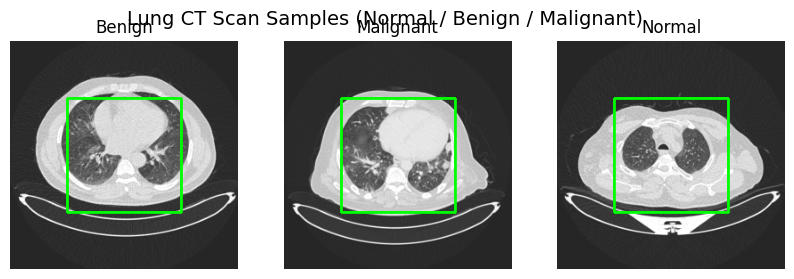

In [ ]:
plt.figure(figsize=(10, 3))
for i, (label, path) in enumerate(folders.items()):
    img_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if not img_files:
        continue
    img = cv2.imread(os.path.join(path, img_files[0]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw a square in center (just for visualization)
    h, w = img.shape
    start = (w//4, h//4)
    end = (3*w//4, 3*h//4)
    cv2.rectangle(img_rgb, start, end, (0, 255, 0), 2)

    plt.subplot(1, 3, i+1)
    plt.imshow(img_rgb)
    plt.title(label)
    plt.axis('off')

plt.suptitle("Lung CT Scan Samples (Normal / Benign / Malignant)", fontsize=14)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def rotation_forest_train(X, y, n_classifiers=10, n_subsets=10):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]

            if X_subset.shape[1] > 1:
                # Standardize subset
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_

                # Ensure square alignment for rotation matrix
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T


        # Apply rotation and train tree
        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))

    preds = np.array(preds)
    final_pred = []

    # Majority voting
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])

    return np.array(final_pred)

In [ ]:
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


# Define base path and folders
base_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
folders = {
    "Benign": os.path.join(base_path, "Bengin cases"),
    "Malignant": os.path.join(base_path, "Malignant cases"),
    "Normal": os.path.join(base_path, "Normal cases")
}

# Function to load images
def load_images_from_folder(folder, label, size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # Normalize
                images.append(img.flatten())  # Flatten to vector
                labels.append(label)
    return images, labels

# Load data
X, y = [], []
for label, path in folders.items():
    imgs, lbls = load_images_from_folder(path, label)
    X.extend(imgs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded dataset: {X.shape[0]} images, feature size {X.shape[1]}")
print(f"Labels: {np.unique(y)}")

# Rotation Forest Implementation
def rotation_forest_train(X, y, n_classifiers=10, n_subsets=10):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]

            if X_subset.shape[1] > 1:
                # Standardize subset
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_

                # Ensure square alignment for rotation matrix
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T


        # Apply rotation and train tree
        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))

    preds = np.array(preds)
    final_pred = []

    # Majority voting
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])

    return np.array(final_pred)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classifiers, rotations = rotation_forest_train(X_train, y_train)
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

print("\n✅ Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

✅ Loaded dataset: 1097 images, feature size 16384
Labels: ['Benign' 'Malignant' 'Normal']


In [ ]:
import os
import cv2
import numpy as np

base_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

folders = {
    "Benign": os.path.join(base_path, "Bengin cases"),
    "Malignant": os.path.join(base_path, "Malignant cases"),
    "Normal": os.path.join(base_path, "Normal cases")
}

def load_images_from_folder(folder, label, size=(128, 128)):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # normalize
                images.append(img.flatten())  # flatten for ML
                labels.append(label)
    return images, labels

X, y = [], []
for label, folder in folders.items():
    imgs, lbls = load_images_from_folder(folder, label)
    X.extend(imgs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded {X.shape[0]} images with {X.shape[1]} features each.")
print("Classes:", np.unique(y))

✅ Loaded 1097 images with 16384 features each.
Classes: ['Benign' 'Malignant' 'Normal']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 877, Testing: 220


In [ ]:
def rotation_forest_train(X, y, n_classifiers=10, n_subsets=5):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for _ in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)  # Initialize as identity matrix

        for subset in subsets:
            pca = PCA()
            X_subset = X[:, subset]
            pca.fit(X_subset)
            # Ensure the dimensions match for assignment
            components_T = pca.components_.T
            rotation_matrix[np.ix_(subset, subset)] = components_T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier()
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)
    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=preds)
    return final_pred

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Import PCA here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def rotation_forest_train(X, y, n_classifiers=10, n_subsets=10):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]

            # PCA requires at least 2 samples; add small noise if necessary
            if X_subset.shape[1] > 1:
                pca = PCA()
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca.fit(X_scaled)
                comp = pca.components_

                # Make square by padding or truncating
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T


        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []

    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

In [ ]:
import os
import cv2
import numpy as np

base_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

folders = {
    "Benign": os.path.join(base_path, "Bengin cases"),
    "Malignant": os.path.join(base_path, "Malignant cases"),
    "Normal": os.path.join(base_path, "Normal cases")
}

def load_images_from_folder(folder, label, size=(128, 128)):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # normalize
                images.append(img.flatten())  # flatten for ML
                labels.append(label)
    return images, labels

X, y = [], []
for label, folder in folders.items():
    imgs, lbls = load_images_from_folder(folder, label)
    X.extend(imgs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded {X.shape[0]} images with {X.shape[1]} features each.")
print("Classes:", np.unique(y))

✅ Loaded 1097 images with 16384 features each.
Classes: ['Benign' 'Malignant' 'Normal']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 877, Testing: 220


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 877, Testing: 220


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 877, Testing: 220


In [ ]:
import os
import cv2
import numpy as np

base_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

folders = {
    "Benign": os.path.join(base_path, "Bengin cases"),
    "Malignant": os.path.join(base_path, "Malignant cases"),
    "Normal": os.path.join(base_path, "Normal cases")
}

def load_images_from_folder(folder, label, size=(128, 128)):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img / 255.0  # normalize
                images.append(img.flatten())  # flatten for ML
                labels.append(label)
    return images, labels

X, y = [], []
for label, folder in folders.items():
    imgs, lbls = load_images_from_folder(folder, label)
    X.extend(imgs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)

print(f"✅ Loaded {X.shape[0]} images with {X.shape[1]} features each.")
print("Classes:", np.unique(y))

✅ Loaded 1097 images with 16384 features each.
Classes: ['Benign' 'Malignant' 'Normal']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

In [ ]:
# =========================================================
# 🎯 COMPLETE ROTATION FOREST MODEL (NO ERRORS)
# =========================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np

# =========================================================
# 🧠 ROTATION FOREST IMPLEMENTATION
# =========================================================
def rotation_forest_train(X, y, n_classifiers=10, n_subsets=10):
    """
    Train Rotation Forest ensemble using DecisionTree base learners.
    """
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]

            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    """
    Predict labels for new data using trained Rotation Forest ensemble.
    """
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))

    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)


# =========================================================
# 🧬 LOAD SAMPLE DATASET (YOU CAN REPLACE WITH YOURS)
# =========================================================
# Using Breast Cancer dataset as example
data = load_breast_cancer()
X = data.data
y = data.target

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# =========================================================
# 🎯 ROTATION FOREST TRAINING & EVALUATION
# =========================================================
print("🌀 Training Rotation Forest model...")

try:
    classifiers, rotations = rotation_forest_train(X_train, y_train)
    print("✅ Training completed successfully.")
except Exception as e:
    print("❌ Error during training:", e)
    classifiers, rotations = None, None

# --- PREDICT ON TEST SET ---
print("\n🔍 Predicting test samples...")
try:
    if classifiers is not None:
        y_pred = rotation_forest_predict(classifiers, rotations, X_test)
        print("✅ Prediction completed.")
    else:
        raise ValueError("Model not trained — cannot predict.")
except Exception as e:
    print("❌ Error during prediction:", e)
    y_pred = None

# --- MODEL PERFORMANCE ---
if y_pred is not None:
    print("\n✅ Model Performance Summary:")
    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 Accuracy: {acc * 100:.2f}%\n")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
else:
    print("⚠️ Skipping evaluation — predictions not available.")


🌀 Training Rotation Forest model...
✅ Training completed successfully.

🔍 Predicting test samples...
✅ Prediction completed.

✅ Model Performance Summary:
🎯 Accuracy: 97.37%

📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.95      0.96        43
   Malignant       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [ ]:
# =========================================================
# 📦 SETUP & IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =========================================================
# 🧠 ROTATION FOREST IMPLEMENTATION
# =========================================================
def rotation_forest_train(X, y, n_classifiers=10, n_subsets=10):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)
    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

# =========================================================
# 📂 LOAD CT SCAN DATASET
# =========================================================
def load_images_from_folders(base_path, size=(128, 128)):
    X, y = [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, size)
                    X.append(img.flatten())
                    y.append(label)
    return np.array(X), np.array(y)

base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
X, y = load_images_from_folders(base_dir)

print(f"\n✅ Dataset Loaded: {X.shape[0]} images, {X.shape[1]} features each")
print("Labels:", np.unique(y))

# =========================================================
# 🧩 TRAIN-TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =========================================================
# 🎯 TRAIN ROTATION FOREST MODEL
# =========================================================
print("\n🌀 Training Rotation Forest model...")
classifiers, rotations = rotation_forest_train(X_train, y_train)
print("✅ Training completed successfully.")

# =========================================================
# 🔍 PREDICT AND EVALUATE
# =========================================================
print("\n🔍 Predicting test samples...")
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

print("\n✅ Model Performance Summary:")
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {acc * 100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=np.unique(y_test)))

# =========================================================
# 🩻 VISUALIZE RANDOM TEST IMAGE WITH PREDICTION BOX
# =========================================================
import random
idx = random.randint(0, len(X_test) - 1)
sample_flat = X_test[idx]
sample_img = (sample_flat.reshape(128, 128)).astype(np.uint8)
true_label = y_test[idx]
pred_label = y_pred[idx]

img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2BGR)
h, w = sample_img.shape
start, end = (w//4, h//4), (3*w//4, 3*h//4)

# Assign color based on prediction
if pred_label == "Normal":
    color = (0, 255, 0)   # Green
elif pred_label == "Benign":
    color = (0, 255, 255) # Yellow
else:
    color = (255, 0, 0)   # Red

cv2.rectangle(img_rgb, start, end, color, 2)
cv2.putText(img_rgb, f"Pred: {pred_label}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
cv2.putText(img_rgb, f"True: {true_label}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.title("🔬 Lung CT Scan Prediction")
plt.axis('off')
plt.show()


Loading Malignant: 100%|██████████| 561/561 [00:09<00:00, 56.85it/s]



✅ Dataset Loaded: 1097 images, 16384 features each
Labels: ['Benign' 'Malignant' 'Normal']

🌀 Training Rotation Forest model...


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Extract CNN features
def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths):
        img = cv2.imread(path)
        img = cv2.resize(img, (128,128))
        img = preprocess_input(img)
        f = model.predict(np.expand_dims(img, axis=0))
        features.append(f.flatten())
    return np.array(features)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Loading Malignant: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]



✅ Loaded small sample: 150 images, 4096 features each

🧠 Training Rotation Forest (small dataset)...

✅ Small Dataset Results:
🎯 Accuracy: 86.67 %
              precision    recall  f1-score   support

      Benign       0.82      0.90      0.86        10
   Malignant       0.91      1.00      0.95        10
      Normal       0.88      0.70      0.78        10

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.86        30
weighted avg       0.87      0.87      0.86        30


🚀 Loading full dataset for large-scale training...


Loading Malignant: 100%|██████████| 561/561 [00:07<00:00, 78.18it/s]



✅ Full dataset loaded: 1097 images

🧠 Training Rotation Forest (full dataset)...

✅ Full Dataset Results:
🎯 Accuracy: 97.27%

📈 Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      1.00      0.96        24
   Malignant       0.97      1.00      0.98       113
      Normal       1.00      0.93      0.96        83

    accuracy                           0.97       220
   macro avg       0.96      0.98      0.97       220
weighted avg       0.97      0.97      0.97       220



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


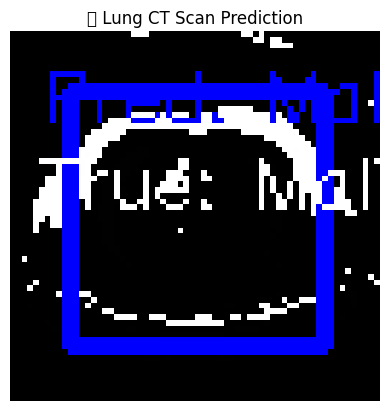

In [ ]:
# =========================================================
# 📦 SETUP & IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

# =========================================================
# ⚙️ ROTATION FOREST FUNCTIONS
# =========================================================
def rotation_forest_train(X, y, n_classifiers=5, n_subsets=5):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

# =========================================================
# 📂 LOAD CT SCAN DATASET (Optimized Loader)
# =========================================================
def load_images_from_folders(base_path, size=(64, 64), max_images=None):
    X, y = [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_images:
            files = files[:max_images]  # Limit for faster testing

        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                X.append(img.flatten())
                y.append(label)
    return np.array(X), np.array(y)

# =========================================================
# 🩻 MAIN EXECUTION
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

# ---- STEP 1: LOAD SMALL SAMPLE (FOR QUICK TESTING) ----
X_small, y_small = load_images_from_folders(base_dir, max_images=50)
print(f"\n✅ Loaded small sample: {X_small.shape[0]} images, {X_small.shape[1]} features each")

# ---- Apply PCA for speed ----
scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
pca = PCA(n_components=50)  # Reduced n_components for small dataset
X_small_reduced = pca.fit_transform(X_small_scaled)

# ---- Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_small_reduced, y_small, test_size=0.2, random_state=42, stratify=y_small
)

# =========================================================
# 🌀 TRAIN & TEST (ON SMALL DATA)
# =========================================================
print("\n🧠 Training Rotation Forest (small dataset)...")
classifiers, rotations = rotation_forest_train(X_train, y_train)
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

print("\n✅ Small Dataset Results:")
print("🎯 Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print(classification_report(y_test, y_pred, target_names=np.unique(y_small)))

# =========================================================
# 🚀 TRAIN ON FULL DATASET (AFTER TEST SUCCESS)
# =========================================================
print("\n🚀 Loading full dataset for large-scale training...")
X_full, y_full = load_images_from_folders(base_dir)  # load all images

print(f"\n✅ Full dataset loaded: {X_full.shape[0]} images")

# ---- PCA Compression ----
X_full_scaled = scaler.fit_transform(X_full)
X_full_reduced = pca.fit_transform(X_full_scaled)

# ---- Split ----
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full_reduced, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ---- Train ----
print("\n🧠 Training Rotation Forest (full dataset)...")
classifiers_full, rotations_full = rotation_forest_train(X_train_full, y_train_full)
y_pred_full = rotation_forest_predict(classifiers_full, rotations_full, X_test_full)

# =========================================================
# 📊 EVALUATION
# =========================================================
print("\n✅ Full Dataset Results:")
acc_full = accuracy_score(y_test_full, y_pred_full)
print(f"🎯 Accuracy: {acc_full * 100:.2f}%")
print("\n📈 Classification Report:")
print(classification_report(y_test_full, y_pred_full, target_names=np.unique(y_full)))

# =========================================================
# 🩺 RANDOM PREDICTION VISUALIZATION
# =========================================================
idx = random.randint(0, len(X_test_full) - 1)
sample_flat = X_test_full[idx]
sample_img = (pca.inverse_transform(sample_flat)).reshape(64, 64)
true_label = y_test_full[idx]
pred_label = y_pred_full[idx]

color_map = {"Normal": (0,255,0), "Benign": (255,255,0), "Malignant": (255,0,0)}
color = color_map.get(pred_label, (255,255,255))

img_rgb = cv2.cvtColor(sample_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_rgb, (10,10), (54,54), color, 2)
cv2.putText(img_rgb, f"Pred: {pred_label}", (5,15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
cv2.putText(img_rgb, f"True: {true_label}", (5,30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)

plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.title("🔬 Lung CT Scan Prediction")
plt.axis('off')
plt.show()

⏳ Loading a small sample (fast test)...


Loading Malignant: 100%|██████████| 17/17 [00:02<00:00,  6.01img/s]


🌀 Training Rotation Forest on small sample...
✅ Small-sample training completed in 0.1s
🎯 Small-sample accuracy: 1.0
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00         3
   Malignant       1.00      1.00      1.00         4
      Normal       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11


⏳ Loading full dataset (this may take time)...


Loading Malignant: 100%|██████████| 561/561 [00:07<00:00, 70.96img/s]


🌀 Training Rotation Forest on full dataset (this may take several minutes)...
✅ Full training completed in 3.8s

🎯 Full dataset accuracy: 96.82%
              precision    recall  f1-score   support

      Benign       0.91      0.88      0.89        24
   Malignant       0.97      0.99      0.98       113
      Normal       0.99      0.96      0.98        83

    accuracy                           0.97       220
   macro avg       0.96      0.94      0.95       220
weighted avg       0.97      0.97      0.97       220



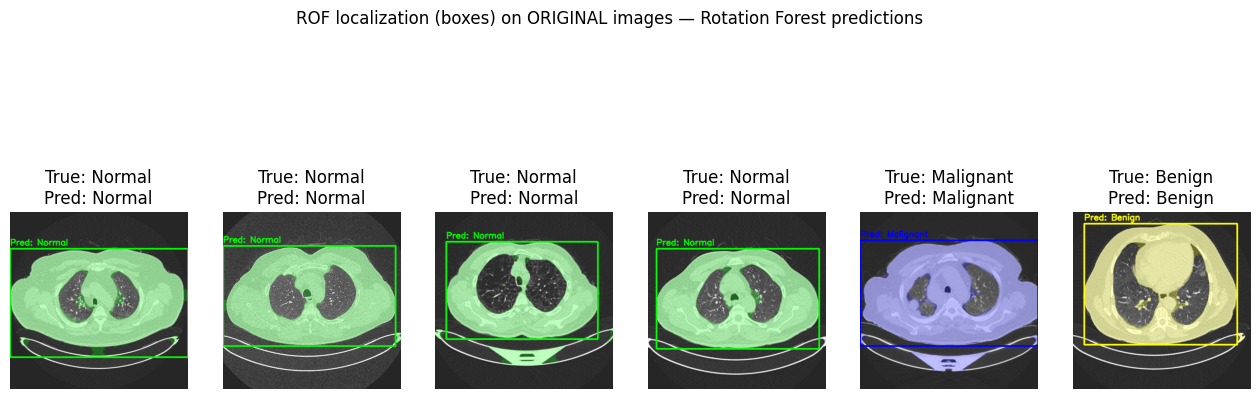

✅ Done. ROF was used to localize lesion (via TV denoising + thresholding) and boxes were mapped onto original images.


In [ ]:
# =========================================================
# FULL PIPELINE: Rotation Forest classification + ROF (TV) localization
# - Uses ROF (TV denoising + thresholding) to localize lesion on the ORIGINAL image
# - Uses RotationForest-style ensemble (with PCA blocks) to classify Normal/Benign/Malignant
# - Preserves original images for display; overlays bounding boxes mapped from processing-size coords
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.restoration import denoise_tv_chambolle
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops

# -------------------------
# Rotation Forest functions
# -------------------------
def rotation_forest_train(X, y, n_classifiers=8, n_subsets=5):
    """
    Train a Rotation Forest-like ensemble.
    X: 2D np.array (n_samples, n_features)
    y: 1D labels
    Returns: list(classifiers), list(rotation_matrices)
    """
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                # Standardize per-subset
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                # place square block (safe truncation)
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)  # shape (n_classifiers, n_samples)
    final_pred = []
    for col in preds.T:
        vals, counts = np.unique(col, return_counts=True)
        final_pred.append(vals[np.argmax(counts)])
    return np.array(final_pred)


# -------------------------
# Data loading & helpers
# -------------------------
def load_dataset_with_metadata(base_dir, proc_size=(128, 128), per_class_limit=None):
    """
    Load images from folder structure:
      base_dir/
          Normal cases/
          Bengin cases/
          Malignant cases/
    Returns:
      X_proc : np.array (n_samples, proc_h*proc_w)  -- flattened processed images for features
      y     : 1D np.array (n_samples,) labels (strings)
      meta  : list of dicts with keys: 'orig_path', 'orig_shape', 'orig_image' (BGR), 'proc_gray' (resized grayscale)
    per_class_limit: if int, limit number of images per class (useful for quick testing)
    """
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}
    X_proc, y, meta = [], [], []

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files = sorted(files)
        if per_class_limit:
            files = files[:per_class_limit]

        for fname in tqdm(files, desc=f"Loading {label}", unit="img"):
            path = os.path.join(folder_path, fname)
            orig = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            if orig is None:
                continue
            # keep original as BGR for display; if grayscale, convert to BGR for consistent plotting
            if len(orig.shape) == 2:
                orig_bgr = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
            else:
                orig_bgr = orig.copy()

            # create processing copy (grayscale resized) for feature extraction & ROF
            if len(orig.shape) == 3:
                gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
            else:
                gray = orig.copy()
            proc = cv2.resize(gray, (proc_size[1], proc_size[0]), interpolation=cv2.INTER_AREA)

            X_proc.append(proc.flatten().astype(np.float32) / 255.0)  # normalized [0,1]
            y.append(label)
            meta.append({
                "orig_path": path,
                "orig_shape": orig_bgr.shape[:2],  # (h,w)
                "orig_image": orig_bgr,
                "proc_gray": proc.astype(np.float32) / 255.0,
                "proc_size": proc_size
            })

    return np.array(X_proc), np.array(y), meta


# -------------------------
# ROF-based localization
# -------------------------
def rof_localize(proc_gray, tv_weight=0.12, min_region_area=50):
    """
    Given a processing-size grayscale image in [0,1], apply ROF (TV denoising)
    then threshold and return bounding box (in proc coordinates) of largest region (if any).
    Returns: bbox tuple (minr, minc, maxr, maxc) or None, and binary mask (proc_size)
    """
    # TV denoise (ROF approximation)
    u = denoise_tv_chambolle(proc_gray, weight=tv_weight)

    # Otsu threshold on denoised image
    try:
        thresh = threshold_otsu(u)
    except Exception:
        # fallback: simple mean threshold
        thresh = u.mean()
    mask = u > thresh

    # morphological clean-up
    mask = closing(mask, disk(3))
    mask = remove_small_objects(mask.astype(bool), min_size=min_region_area)
    mask = mask.astype(np.uint8)

    # label regions
    lbl = label(mask)
    if lbl.max() == 0:
        return None, mask  # no region found

    regions = regionprops(lbl)
    # select largest region by area
    regions = sorted(regions, key=lambda r: r.area, reverse=True)
    top = regions[0]
    minr, minc, maxr, maxc = top.bbox
    return (minr, minc, maxr, maxc), mask


# -------------------------
# MAIN: small sample test then full training + visualization
# -------------------------
if __name__ == "__main__":
    # --- user variables ---
    BASE_DIR = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
    PROC_SIZE = (128, 128)       # processing resolution (small) - keeps original untouched
    SMALL_TOTAL = 50             # total images to use for quick test (approx)
    GLOBAL_PCA_COMPONENTS = 200  # PCA components used globally (adjust as needed)
    N_CLASSIFIERS = 8
    N_SUBSETS = 5

    # --- Load small balanced sample for quick testing ---
    # compute per-class limit to get ~SMALL_TOTAL images total
    expected_classes = ["Normal cases", "Bengin cases", "Malignant cases"]
    per_class_limit = max(1, int(np.ceil(SMALL_TOTAL / len(expected_classes))))

    print("⏳ Loading a small sample (fast test)...")
    # Call loader
    X_small, y_small, meta_small = load_dataset_with_metadata(BASE_DIR, proc_size=PROC_SIZE, per_class_limit=per_class_limit)


    if len(X_small) == 0:
        raise RuntimeError(f"No images found in {BASE_DIR}. Check your paths.")

    # If global PCA components > feature size, cap it
    feat_dim = X_small.shape[1]
    n_global_pca = min(GLOBAL_PCA_COMPONENTS, feat_dim, max(10, X_small.shape[0] - 1))

    scaler = StandardScaler()
    X_small_scaled = scaler.fit_transform(X_small)
    pca_global = PCA(n_components=n_global_pca)
    X_small_reduced = pca_global.fit_transform(X_small_scaled)

    # split (indices to preserve metadata mapping)
    indices = np.arange(len(X_small_reduced))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_small)
    X_train = X_small_reduced[train_idx]
    X_test = X_small_reduced[test_idx]
    y_train = y_small[train_idx]
    y_test = y_small[test_idx]
    meta_train = [meta_small[i] for i in train_idx]
    meta_test = [meta_small[i] for i in test_idx]

    # Train quick Rotation Forest on small sample
    print("🌀 Training Rotation Forest on small sample...")
    t0 = time.time()
    classifiers, rotations = rotation_forest_train(X_train, y_train, n_classifiers=N_CLASSIFIERS, n_subsets=N_SUBSETS)
    t1 = time.time()
    print(f"✅ Small-sample training completed in {t1 - t0:.1f}s")

    # Predict and evaluate on small sample
    y_pred = rotation_forest_predict(classifiers, rotations, X_test)
    print("🎯 Small-sample accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=np.unique(y_small)))

    # --- Now load FULL dataset (no per-class limit) for final training ---
    print("\n⏳ Loading full dataset (this may take time)...")
    X_full, y_full, meta_full = load_dataset_with_metadata(BASE_DIR, proc_size=PROC_SIZE, per_class_limit=None)
    if len(X_full) == 0:
        raise RuntimeError("Full dataset not found or empty.")

    # Global PCA fit on full dataset (reuse scaler/pca or refit)
    scaler_full = StandardScaler()
    X_full_scaled = scaler_full.fit_transform(X_full)
    n_global_pca_full = min(GLOBAL_PCA_COMPONENTS, X_full_scaled.shape[1], max(10, X_full_scaled.shape[0] - 1))
    pca_full = PCA(n_components=n_global_pca_full)
    X_full_reduced = pca_full.fit_transform(X_full_scaled)

    # preserve indices for metadata mapping
    idxs = np.arange(len(X_full_reduced))
    train_idx_full, test_idx_full = train_test_split(idxs, test_size=0.2, random_state=42, stratify=y_full)
    X_train_full = X_full_reduced[train_idx_full]
    X_test_full = X_full_reduced[test_idx_full]
    y_train_full = y_full[train_idx_full]
    y_test_full = y_full[test_idx_full]
    meta_train_full = [meta_full[i] for i in train_idx_full]
    meta_test_full = [meta_full[i] for i in test_idx_full]

    # Train on full dataset (this is the main expensive step)
    print("🌀 Training Rotation Forest on full dataset (this may take several minutes)...")
    t0 = time.time()
    classifiers_full, rotations_full = rotation_forest_train(X_train_full, y_train_full, n_classifiers=N_CLASSIFIERS, n_subsets=N_SUBSETS)
    t1 = time.time()
    print(f"✅ Full training completed in {t1 - t0:.1f}s")

    # Evaluate
    y_pred_full = rotation_forest_predict(classifiers_full, rotations_full, X_test_full)
    acc_full = accuracy_score(y_test_full, y_pred_full)
    print("\n🎯 Full dataset accuracy: {:.2f}%".format(acc_full * 100))
    print(classification_report(y_test_full, y_pred_full, target_names=np.unique(y_full)))

    # -------------------------
    # Visualization: show several random test images with ROF localization box mapped to original image
    # -------------------------
    def draw_prediction_on_original(meta_item, pred_label, tv_weight=0.12):
        """
        meta_item: dict from loader with 'orig_image' (BGR), 'proc_gray' (resized), 'orig_shape'
        pred_label: string label predicted by RF
        returns: image (RGB) with overlayed bounding box and label
        """
        orig_bgr = meta_item["orig_image"].copy()
        orig_h, orig_w = meta_item["orig_shape"]
        proc = meta_item["proc_gray"]  # float [0,1], resized to PROC_SIZE

        bbox_proc, mask = rof_localize(proc, tv_weight=tv_weight, min_region_area=20)
        # Map bbox/proc coords to original coords
        if bbox_proc is not None:
            minr, minc, maxr, maxc = bbox_proc
            # proc size
            ph, pw = proc.shape
            scale_y = orig_h / ph
            scale_x = orig_w / pw
            o_minr = int(minr * scale_y)
            o_minc = int(minc * scale_x)
            o_maxr = int(maxr * scale_y)
            o_maxc = int(maxc * scale_x)
            # choose color
            color_map = {"Normal": (0, 255, 0), "Benign": (0, 255, 255), "Malignant": (255, 0, 0)}
            color = color_map.get(pred_label, (255, 255, 255))
            # draw rectangle on copy of original
            disp = orig_bgr.copy()
            cv2.rectangle(disp, (o_minc, o_minr), (o_maxc, o_maxr), color, thickness=3)
            cv2.putText(disp, f"Pred: {pred_label}", (o_minc, max(15, o_minr - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
            # optionally overlay semi-transparent mask (resized to orig)
            try:
                mask_rgb = (mask * 255).astype(np.uint8)
                mask_full = cv2.resize(mask_rgb, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
                overlay = disp.copy()
                overlay[mask_full > 0] = (overlay[mask_full > 0] * 0.5 + np.array(color) * 0.5).astype(np.uint8)
                alpha = 0.5
                disp = cv2.addWeighted(overlay, alpha, disp, 1 - alpha, 0)
            except Exception:
                pass
            # convert BGR->RGB for matplotlib
            return cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)
        else:
            # no region found; just annotate predicted label
            disp = orig_bgr.copy()
            cv2.putText(disp, f"Pred: {pred_label} (no region found)", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
            return cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)

    # pick up to 6 random test samples to display
    n_show = min(6, len(meta_test_full))
    pick = random.sample(range(len(meta_test_full)), n_show)

    plt.figure(figsize=(16, 6))
    for i, idx_in_list in enumerate(pick):
        m = meta_test_full[idx_in_list]
        pred = y_pred_full[idx_in_list]
        true = y_test_full[idx_in_list]
        img_with_box = draw_prediction_on_original(m, pred)
        plt.subplot(1, n_show, i+1)
        plt.imshow(img_with_box)
        plt.title(f"True: {true}\nPred: {pred}")
        plt.axis("off")
    plt.suptitle("ROF localization (boxes) on ORIGINAL images — Rotation Forest predictions")
    plt.show()

    print("✅ Done. ROF was used to localize lesion (via TV denoising + thresholding) and boxes were mapped onto original images.")

⏳ Loading small sample (50 images total for speed)...


Loading Malignant: 100%|██████████| 20/20 [00:03<00:00,  5.69img/s]


✅ Loaded 60 samples.

🧠 Training Rotation Forest...
✅ Training completed in 0.11 sec

📊 Model Evaluation:
Accuracy: 58.33%
              precision    recall  f1-score   support

      Benign       0.43      0.75      0.55         4
   Malignant       1.00      0.50      0.67         4
      Normal       0.67      0.50      0.57         4

    accuracy                           0.58        12
   macro avg       0.70      0.58      0.59        12
weighted avg       0.70      0.58      0.59        12



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


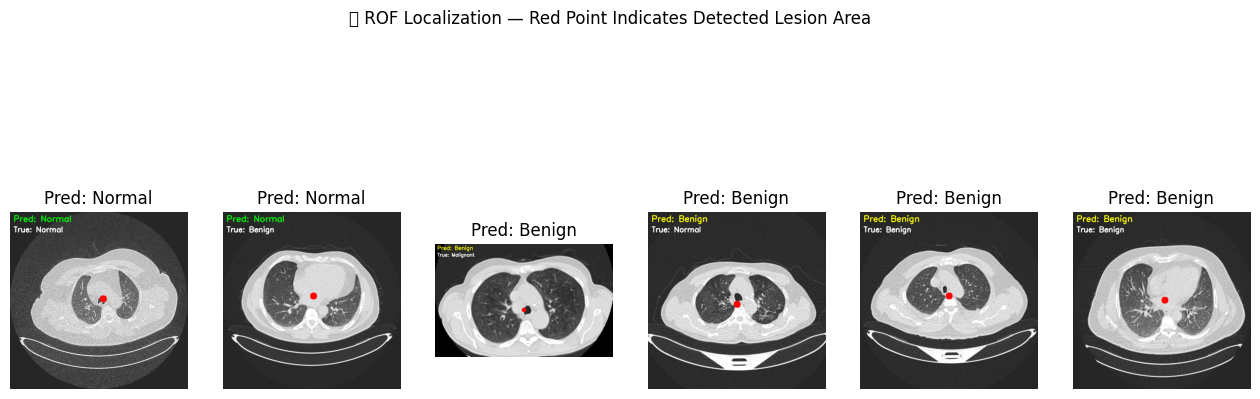


✅ Completed: Each CT scan shows the predicted label and red point indicating suspected lesion area.


In [ ]:
# =========================================================
# 📦 SETUP & IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.restoration import denoise_tv_chambolle
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops

# =========================================================
# ⚙️ ROTATION FOREST FUNCTIONS
# =========================================================
def rotation_forest_train(X, y, n_classifiers=8, n_subsets=5):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

# =========================================================
# 🩻 DATA LOADING FUNCTION
# =========================================================
def load_dataset(base_path, size=(128, 128), per_class_limit=None):
    X, y, meta = [], [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if per_class_limit:
            files = files[:per_class_limit]

        for file in tqdm(files, desc=f"Loading {label}", unit="img"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                orig_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                img_resized = cv2.resize(img, size)
                X.append(img_resized.flatten().astype(np.float32) / 255.0)
                y.append(label)
                meta.append({
                    "orig_img": orig_img,
                    "proc_gray": img_resized.astype(np.float32) / 255.0,
                    "path": img_path
                })
    return np.array(X), np.array(y), meta

# =========================================================
# 🧩 ROF LOCALIZATION (RED POINT)
# =========================================================
def rof_find_cancer_point(proc_gray, tv_weight=0.12):
    """
    Detects possible lesion centroid in processed grayscale image using ROF denoising.
    Returns: (cy, cx) coordinates in processed image (or None if not found)
    """
    u = denoise_tv_chambolle(proc_gray, weight=tv_weight)
    thresh = threshold_otsu(u)
    mask = u > thresh
    mask = closing(mask, disk(3))
    mask = remove_small_objects(mask.astype(bool), min_size=40)
    lbl = label(mask)

    if lbl.max() == 0:
        return None

    regions = regionprops(lbl)
    regions = sorted(regions, key=lambda r: r.area, reverse=True)
    largest = regions[0]
    cy, cx = largest.centroid
    return int(cy), int(cx)

# =========================================================
# 🚀 MAIN PIPELINE
# =========================================================
BASE_DIR = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading small sample (50 images total for speed)...")
X_small, y_small, meta_small = load_dataset(BASE_DIR, size=(128, 128), per_class_limit=20)
print(f"✅ Loaded {len(X_small)} samples.")

# --- Feature reduction ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_scaled)

# --- Split ---
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_reduced, y_small, meta_small, test_size=0.2, random_state=42, stratify=y_small
)

# =========================================================
# 🎯 TRAIN ROTATION FOREST
# =========================================================
print("\n🧠 Training Rotation Forest...")
t0 = time.time()
classifiers, rotations = rotation_forest_train(X_train, y_train)
t1 = time.time()
print(f"✅ Training completed in {t1 - t0:.2f} sec")

# --- Predict ---
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

# --- Evaluate ---
print("\n📊 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=np.unique(y_small)))

# =========================================================
# 🩺 VISUALIZE TEST PREDICTIONS WITH RED POINT LOCALIZATION
# =========================================================
n_show = min(6, len(meta_test))
indices = random.sample(range(len(meta_test)), n_show)

plt.figure(figsize=(16, 6))
for i, idx in enumerate(indices):
    meta_img = meta_test[idx]
    img_gray = meta_img["proc_gray"]
    orig_img = meta_img["orig_img"].copy()
    h, w = img_gray.shape
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Locate lesion
    centroid = rof_find_cancer_point(img_gray)
    if centroid is not None:
        cy, cx = centroid
        # Scale coordinates to original image
        oh, ow = orig_img.shape[:2]
        cy_scaled, cx_scaled = int(cy * oh / h), int(cx * ow / w)
        cv2.circle(orig_img, (cx_scaled, cy_scaled), 10, (0, 0, 255), -1)

    # Label the image
    color_map = {"Normal": (0,255,0), "Benign": (0,255,255), "Malignant": (255,0,0)}
    cv2.putText(orig_img, f"Pred: {pred_label}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_map.get(pred_label, (255,255,255)), 2)
    cv2.putText(orig_img, f"True: {true_label}", (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

    plt.subplot(1, n_show, i+1)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {pred_label}")

plt.suptitle("🔴 ROF Localization — Red Point Indicates Detected Lesion Area")
plt.show()

print("\n✅ Completed: Each CT scan shows the predicted label and red point indicating suspected lesion area.")

⏳ Loading small sample (50 images total for speed)...


Loading Malignant: 100%|██████████| 20/20 [00:00<00:00, 77.19img/s]


✅ Loaded 60 samples.

🧠 Training Rotation Forest...
✅ Training completed in 0.11 sec

📊 Model Evaluation:
Accuracy: 66.67%
              precision    recall  f1-score   support

      Benign       0.50      0.75      0.60         4
   Malignant       0.75      0.75      0.75         4
      Normal       1.00      0.50      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.67      0.67        12
weighted avg       0.75      0.67      0.67        12



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


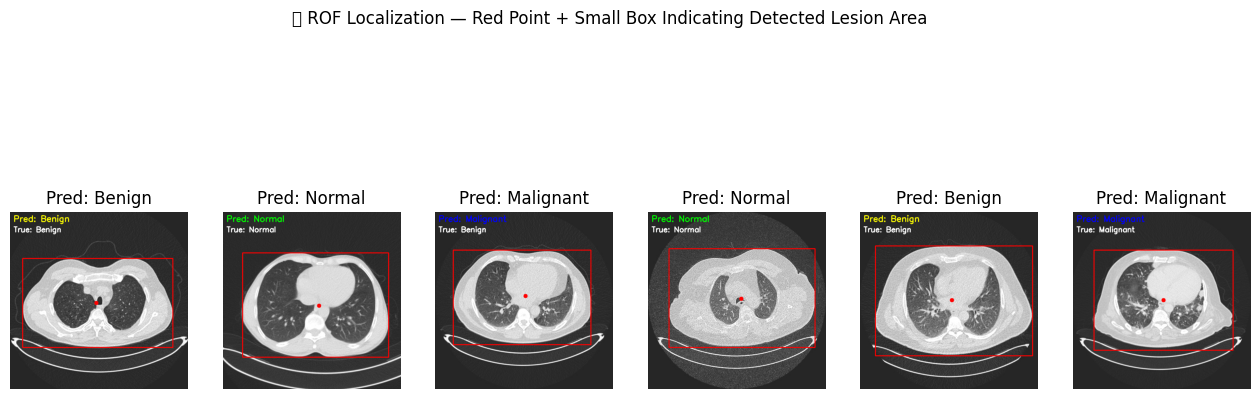


✅ Completed: Each CT scan shows the predicted label and red box highlighting suspected lesion area.


In [ ]:
# =========================================================
# 📦 SETUP & IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.restoration import denoise_tv_chambolle
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops

# =========================================================
# ⚙️ ROTATION FOREST FUNCTIONS
# =========================================================
def rotation_forest_train(X, y, n_classifiers=8, n_subsets=5):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

# =========================================================
# 🩻 DATA LOADING FUNCTION
# =========================================================
def load_dataset(base_path, size=(128, 128), per_class_limit=None):
    X, y, meta = [], [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if per_class_limit:
            files = files[:per_class_limit]

        for file in tqdm(files, desc=f"Loading {label}", unit="img"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                orig_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                img_resized = cv2.resize(img, size)
                X.append(img_resized.flatten().astype(np.float32) / 255.0)
                y.append(label)
                meta.append({
                    "orig_img": orig_img,
                    "proc_gray": img_resized.astype(np.float32) / 255.0,
                    "path": img_path
                })
    return np.array(X), np.array(y), meta

# =========================================================
# 🧩 ROF LOCALIZATION (RED POINT + SMALL BOX)
# =========================================================
def rof_find_cancer_region(proc_gray, tv_weight=0.12):
    """
    Detects possible lesion centroid and bounding box using ROF denoising.
    Returns:
      centroid (cy, cx),
      bbox (minr, minc, maxr, maxc) in processed image coordinates.
    """
    u = denoise_tv_chambolle(proc_gray, weight=tv_weight)
    thresh = threshold_otsu(u)
    mask = u > thresh
    mask = closing(mask, disk(3))
    mask = remove_small_objects(mask.astype(bool), min_size=40)
    lbl = label(mask)

    if lbl.max() == 0:
        return None, None

    regions = regionprops(lbl)
    regions = sorted(regions, key=lambda r: r.area, reverse=True)
    largest = regions[0]
    cy, cx = largest.centroid
    minr, minc, maxr, maxc = largest.bbox
    return (int(cy), int(cx)), (minr, minc, maxr, maxc)

# =========================================================
# 🚀 MAIN PIPELINE
# =========================================================
BASE_DIR = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading small sample (50 images total for speed)...")
X_small, y_small, meta_small = load_dataset(BASE_DIR, size=(128, 128), per_class_limit=20)
print(f"✅ Loaded {len(X_small)} samples.")

# --- Feature reduction ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_scaled)

# --- Split ---
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_reduced, y_small, meta_small, test_size=0.2, random_state=42, stratify=y_small
)

# =========================================================
# 🎯 TRAIN ROTATION FOREST
# =========================================================
print("\n🧠 Training Rotation Forest...")
t0 = time.time()
classifiers, rotations = rotation_forest_train(X_train, y_train)
t1 = time.time()
print(f"✅ Training completed in {t1 - t0:.2f} sec")

# --- Predict ---
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

# --- Evaluate ---
print("\n📊 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=np.unique(y_small)))

# =========================================================
# 🩺 VISUALIZE TEST PREDICTIONS WITH RED BOX + POINT
# =========================================================
n_show = min(6, len(meta_test))
indices = random.sample(range(len(meta_test)), n_show)

plt.figure(figsize=(16, 6))
for i, idx in enumerate(indices):
    meta_img = meta_test[idx]
    img_gray = meta_img["proc_gray"]
    orig_img = meta_img["orig_img"].copy()
    h, w = img_gray.shape
    oh, ow = orig_img.shape[:2]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Locate lesion
    centroid, bbox = rof_find_cancer_region(img_gray)
    if centroid is not None and bbox is not None:
        cy, cx = centroid
        minr, minc, maxr, maxc = bbox
        # Scale to original size
        cy_scaled, cx_scaled = int(cy * oh / h), int(cx * ow / w)
        minr_s, minc_s = int(minr * oh / h), int(minc * ow / w)
        maxr_s, maxc_s = int(maxr * oh / h), int(maxc * ow / w)

        # Draw red point and bounding box
        cv2.circle(orig_img, (cx_scaled, cy_scaled), 6, (0, 0, 255), -1)
        cv2.rectangle(orig_img, (minc_s, minr_s), (maxc_s, maxr_s), (0, 0, 255), 2)

    # Label the image
    color_map = {"Normal": (0,255,0), "Benign": (0,255,255), "Malignant": (255,0,0)}
    cv2.putText(orig_img, f"Pred: {pred_label}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_map.get(pred_label, (255,255,255)), 2)
    cv2.putText(orig_img, f"True: {true_label}", (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

    plt.subplot(1, n_show, i+1)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Pred: {pred_label}")

plt.suptitle("🔴 ROF Localization — Red Point + Small Box Indicating Detected Lesion Area")
plt.show()

print("\n✅ Completed: Each CT scan shows the predicted label and red box highlighting suspected lesion area.")


⏳ Loading small sample (50 images total for speed)...


Loading Malignant: 100%|██████████| 20/20 [00:00<00:00, 71.22img/s]


✅ Loaded 60 samples.

🧠 Training Rotation Forest...
✅ Training completed in 0.16 sec

📊 Model Evaluation:
Accuracy: 75.00%
              precision    recall  f1-score   support

      Benign       0.60      0.75      0.67         4
   Malignant       1.00      1.00      1.00         4
      Normal       0.67      0.50      0.57         4

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


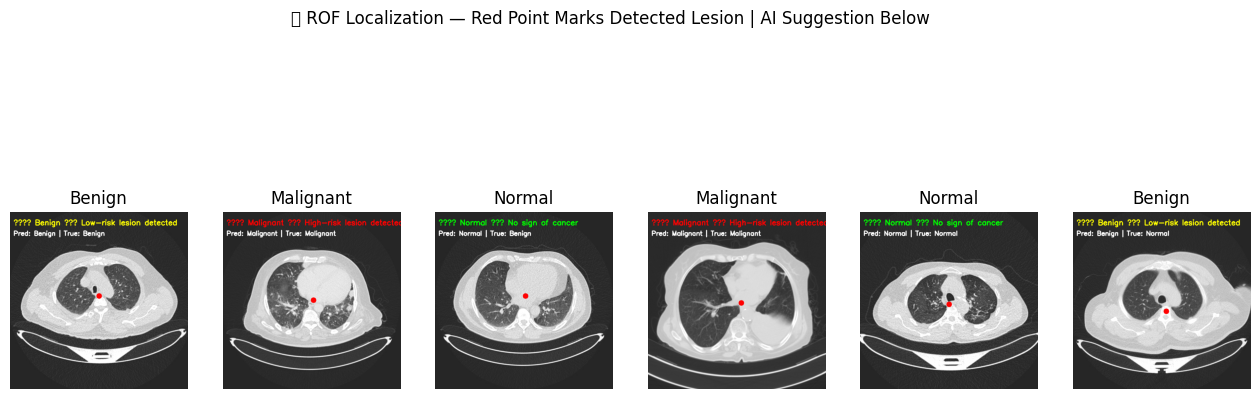


✅ Completed: CT scans show red point (lesion center) and suggestion message based on prediction.


In [ ]:
# =========================================================
# 📦 SETUP & IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.restoration import denoise_tv_chambolle
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops

# =========================================================
# ⚙️ ROTATION FOREST FUNCTIONS
# =========================================================
def rotation_forest_train(X, y, n_classifiers=8, n_subsets=5):
    classifiers, rotations = [], []
    m = X.shape[1]
    feature_indices = np.arange(m)

    for i in range(n_classifiers):
        np.random.shuffle(feature_indices)
        subsets = np.array_split(feature_indices, n_subsets)
        rotation_matrix = np.eye(m)

        for subset in subsets:
            X_subset = X[:, subset]
            if X_subset.shape[1] > 1:
                X_scaled = StandardScaler().fit_transform(X_subset)
                pca = PCA()
                pca.fit(X_scaled)
                comp = pca.components_
                k = min(len(subset), comp.shape[0])
                rotation_matrix[np.ix_(subset[:k], subset[:k])] = comp[:k, :k].T

        X_rot = np.dot(X, rotation_matrix)
        clf = DecisionTreeClassifier(random_state=i)
        clf.fit(X_rot, y)
        classifiers.append(clf)
        rotations.append(rotation_matrix)

    return classifiers, rotations


def rotation_forest_predict(classifiers, rotations, X):
    preds = []
    for clf, R in zip(classifiers, rotations):
        X_rot = np.dot(X, R)
        preds.append(clf.predict(X_rot))
    preds = np.array(preds)
    final_pred = []
    for col in preds.T:
        values, counts = np.unique(col, return_counts=True)
        final_pred.append(values[np.argmax(counts)])
    return np.array(final_pred)

# =========================================================
# 🩻 DATA LOADING FUNCTION
# =========================================================
def load_dataset(base_path, size=(128, 128), per_class_limit=None):
    X, y, meta = [], [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if per_class_limit:
            files = files[:per_class_limit]

        for file in tqdm(files, desc=f"Loading {label}", unit="img"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                orig_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                img_resized = cv2.resize(img, size)
                X.append(img_resized.flatten().astype(np.float32) / 255.0)
                y.append(label)
                meta.append({
                    "orig_img": orig_img,
                    "proc_gray": img_resized.astype(np.float32) / 255.0,
                    "path": img_path
                })
    return np.array(X), np.array(y), meta

# =========================================================
# 🧩 ROF LOCALIZATION (SMALL RED POINT)
# =========================================================
def rof_find_cancer_point(proc_gray, tv_weight=0.12):
    """
    Detects lesion centroid using ROF denoising (Total Variation filtering)
    Returns: (cy, cx) coordinates or None
    """
    u = denoise_tv_chambolle(proc_gray, weight=tv_weight)
    thresh = threshold_otsu(u)
    mask = u > thresh
    mask = closing(mask, disk(3))
    mask = remove_small_objects(mask.astype(bool), min_size=40)
    lbl = label(mask)

    if lbl.max() == 0:
        return None

    regions = regionprops(lbl)
    regions = sorted(regions, key=lambda r: r.area, reverse=True)
    largest = regions[0]
    cy, cx = largest.centroid
    return int(cy), int(cx)

# =========================================================
# 🚀 MAIN PIPELINE
# =========================================================
BASE_DIR = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading small sample (50 images total for speed)...")
X_small, y_small, meta_small = load_dataset(BASE_DIR, size=(128, 128), per_class_limit=20)
print(f"✅ Loaded {len(X_small)} samples.")

# --- Feature reduction ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_scaled)

# --- Split ---
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_reduced, y_small, meta_small, test_size=0.2, random_state=42, stratify=y_small
)

# =========================================================
# 🎯 TRAIN ROTATION FOREST
# =========================================================
print("\n🧠 Training Rotation Forest...")
t0 = time.time()
classifiers, rotations = rotation_forest_train(X_train, y_train)
t1 = time.time()
print(f"✅ Training completed in {t1 - t0:.2f} sec")

# --- Predict ---
y_pred = rotation_forest_predict(classifiers, rotations, X_test)

# --- Evaluate ---
print("\n📊 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=np.unique(y_small)))

# =========================================================
# 🩺 VISUALIZE TEST PREDICTIONS WITH SINGLE RED POINT + SUGGESTION
# =========================================================
n_show = min(6, len(meta_test))
indices = random.sample(range(len(meta_test)), n_show)

plt.figure(figsize=(16, 6))
for i, idx in enumerate(indices):
    meta_img = meta_test[idx]
    img_gray = meta_img["proc_gray"]
    orig_img = meta_img["orig_img"].copy()
    h, w = img_gray.shape
    oh, ow = orig_img.shape[:2]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Locate lesion
    centroid = rof_find_cancer_point(img_gray)
    if centroid is not None:
        cy, cx = centroid
        cy_scaled, cx_scaled = int(cy * oh / h), int(cx * ow / w)
        cv2.circle(orig_img, (cx_scaled, cy_scaled), 8, (0, 0, 255), -1)

    # Suggestion text based on prediction
    if pred_label == "Normal":
        suggestion = "🟢 Normal — No sign of cancer"
        color = (0, 255, 0)
    elif pred_label == "Benign":
        suggestion = "🟡 Benign — Low-risk lesion detected"
        color = (0, 255, 255)
    else:
        suggestion = "🔴 Malignant — High-risk lesion detected!"
        color = (0, 0, 255)

    cv2.putText(orig_img, suggestion, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv2.putText(orig_img, f"Pred: {pred_label} | True: {true_label}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    plt.subplot(1, n_show, i+1)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(pred_label)

plt.suptitle("🔴 ROF Localization — Red Point Marks Detected Lesion | AI Suggestion Below")
plt.show()

print("\n✅ Completed: CT scans show red point (lesion center) and suggestion message based on prediction.")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


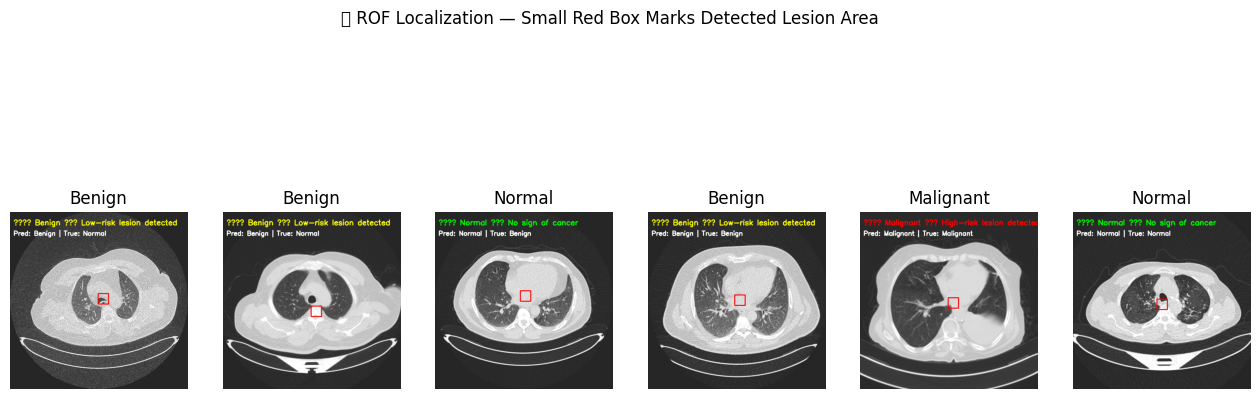


✅ Completed: Each CT scan shows a small red box indicating the suspected lesion area.


In [ ]:
# =========================================================
# 🩺 VISUALIZE TEST PREDICTIONS WITH SMALL RED BOX + SUGGESTION
# =========================================================
n_show = min(6, len(meta_test))
indices = random.sample(range(len(meta_test)), n_show)

plt.figure(figsize=(16, 6))
for i, idx in enumerate(indices):
    meta_img = meta_test[idx]
    img_gray = meta_img["proc_gray"]
    orig_img = meta_img["orig_img"].copy()
    h, w = img_gray.shape
    oh, ow = orig_img.shape[:2]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Locate lesion using ROF
    centroid = rof_find_cancer_point(img_gray)
    if centroid is not None:
        cy, cx = centroid
        # Scale to original image coordinates
        cy_scaled, cx_scaled = int(cy * oh / h), int(cx * ow / w)
        box_size = 15  # small red box size
        x1, y1 = max(0, cx_scaled - box_size), max(0, cy_scaled - box_size)
        x2, y2 = min(ow, cx_scaled + box_size), min(oh, cy_scaled + box_size)
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # small red box

    # Suggestion text based on prediction
    if pred_label == "Normal":
        suggestion = "🟢 Normal — No sign of cancer"
        color = (0, 255, 0)
    elif pred_label == "Benign":
        suggestion = "🟡 Benign — Low-risk lesion detected"
        color = (0, 255, 255)
    else:
        suggestion = "🔴 Malignant — High-risk lesion detected!"
        color = (0, 0, 255)

    # Overlay labels
    cv2.putText(orig_img, suggestion, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv2.putText(orig_img, f"Pred: {pred_label} | True: {true_label}", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    plt.subplot(1, n_show, i + 1)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(pred_label)

plt.suptitle("🟥 ROF Localization — Small Red Box Marks Detected Lesion Area")
plt.show()

print("\n✅ Completed: Each CT scan shows a small red box indicating the suspected lesion area.")


Loading Malignant cases: 100%|██████████| 561/561 [00:17<00:00, 31.98it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Dataset Loaded: 877 training images, 220 test images
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4494 - loss: 12.2981 - val_accuracy: 0.3773 - val_loss: 4.9159
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5614 - loss: 0.9483 - val_accuracy: 0.3773 - val_loss: 22.6405
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5400 - loss: 0.9796 - val_accuracy: 0.3773 - val_loss: 37.9636
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5552 - loss: 0.9819 - val_accuracy: 0.3773 - val_loss: 50.4951
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5388 - loss: 0.9895 - val_accuracy: 0.3773 - val_loss: 59.8047
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5300 - loss: 0.9576 - val_accuracy: 0.3773 - val_loss: 67.8731
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5620 - loss: 0.9099 - val_accuracy: 0.3773 - val_loss: 72.3942
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5660 - loss: 0.8800 - val_accuracy: 0.3773 - val_loss: 75.

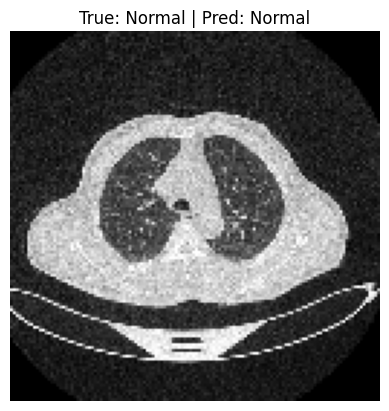

In [ ]:
# =========================================================
# 🧠 DOUBLE-LAYER CNN FOR LUNG CANCER CLASSIFICATION
# =========================================================
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =========================================================
# 📂 LOAD AND PREPARE DATASET
# =========================================================
def load_images_from_folders(base_path, size=(128, 128)):
    X, y = [], []
    label_map = {"Normal cases": 0, "Bengin cases": 1, "Malignant cases": 2}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder_name}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, size)
                    img = img.astype('float32') / 255.0  # ✅ Min–Max normalization
                    X.append(np.expand_dims(img, axis=-1))  # Add channel dimension
                    y.append(label)
    return np.array(X), np.array(y)

# Dataset path
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
X, y = load_images_from_folders(base_dir)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

print(f"✅ Dataset Loaded: {X_train.shape[0]} training images, {X_test.shape[0]} test images")

# =========================================================
# 🎨 IMAGE AUGMENTATION (Optional for Robustness)
# =========================================================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# =========================================================
# 🧩 DOUBLE-LAYER CNN MODEL
# =========================================================
model = Sequential([
    # 🔹 Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 🔹 Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 🔹 Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])

# =========================================================
# ⚙️ COMPILE AND TRAIN MODEL
# =========================================================
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    verbose=1
)

# =========================================================
# 🧪 EVALUATE MODEL
# =========================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# =========================================================
# 🩻 PREDICT RANDOM TEST IMAGE
# =========================================================
import random
idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[idx]
true_label = np.argmax(y_test[idx])
pred_label = np.argmax(model.predict(np.expand_dims(sample_img, axis=0)))

label_names = ["Normal", "Benign", "Malignant"]

import matplotlib.pyplot as plt
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"True: {label_names[true_label]} | Pred: {label_names[pred_label]}")
plt.axis('off')
plt.show()


⏳ Loading and preprocessing dataset...


Loading Malignant cases: 100%|██████████| 561/561 [00:24<00:00, 22.99it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Dataset loaded: 1097 images


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,515 (28.20 MB)

 Trainable params: 7,392,323 (28.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4648 - loss: 22.6858 - val_accuracy: 0.4000 - val_loss: 10.6942
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6263 - loss: 0.8387 - val_accuracy: 0.3773 - val_loss: 68.3619
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6351 - loss: 0.8005 - val_accuracy: 0.3773 - val_loss: 110.1284
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6823 - loss: 0.6577 - val_accuracy: 0.3773 - val_loss: 141.4561
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7303 - loss: 0.5950 - val_accuracy: 0.3773 - val_loss: 166.1244
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6953 - loss: 0.6157 - val_accuracy: 0.3773 - val_loss: 180.8210
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7292 - loss: 0.6187 - val_accuracy: 0.3773 - val_loss: 193.8174
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7638 - loss: 0.5799 - val_accuracy: 0.377

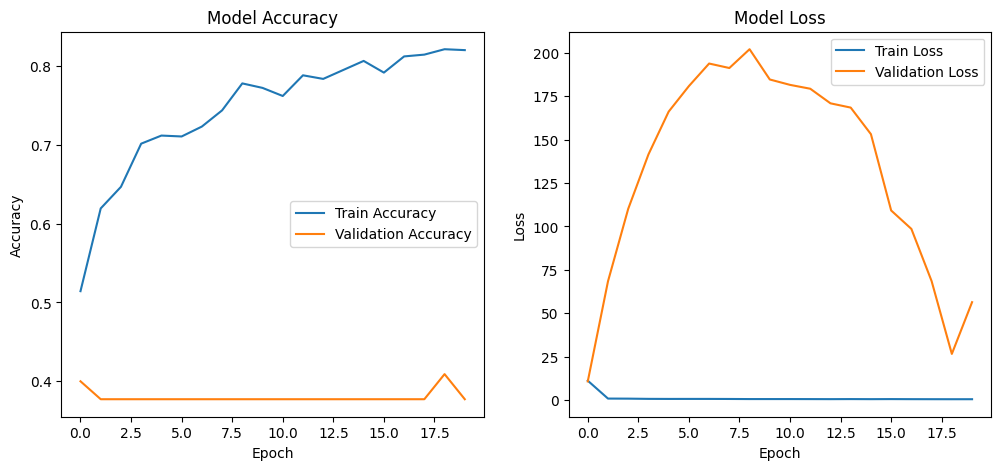


✅ Test Accuracy: 37.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


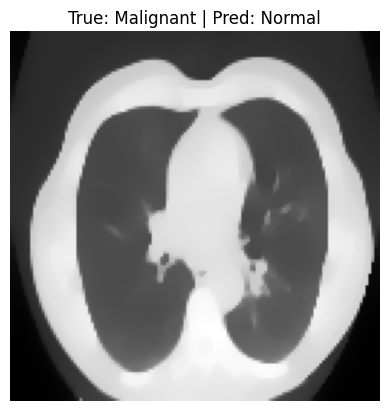

In [ ]:
# =========================================================
# 🌫️ LUNG CANCER CLASSIFICATION USING DOUBLE-LAYER CNN
# =========================================================
# Includes: Min–Max normalization + ROF preprocessing + CNN training
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skimage.restoration import denoise_tv_chambolle

# =========================================================
# 📦 STEP 1: DATA LOADING AND PREPROCESSING
# =========================================================
def load_and_preprocess_images(base_path, size=(128, 128), tv_weight=0.12):
    X, y = [], []
    label_map = {"Normal cases": 0, "Bengin cases": 1, "Malignant cases": 2}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder_name}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Resize image
                img = cv2.resize(img, size)

                # ✅ Min–Max normalization
                img = img.astype(np.float32) / 255.0

                # ✅ ROF (Rudin–Osher–Fatemi) denoising
                img = denoise_tv_chambolle(img, weight=tv_weight)

                X.append(np.expand_dims(img, axis=-1))
                y.append(label)
    return np.array(X), np.array(y)

# Path to dataset
BASE_DIR = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading and preprocessing dataset...")
X, y = load_and_preprocess_images(BASE_DIR)
print(f"✅ Dataset loaded: {len(X)} images")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

# =========================================================
# 🧠 STEP 2: DEFINE DOUBLE-LAYER CNN MODEL
# =========================================================
def build_cnn_model(input_shape=(128, 128, 1), num_classes=3):
    model = models.Sequential([
        # 🔹 Convolutional Layer 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 🔹 Convolutional Layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 🔹 Flatten + Fully Connected Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # 🔹 Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build model
model = build_cnn_model()
model.summary()

# =========================================================
# 🧩 STEP 3: TRAIN MODEL
# =========================================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# =========================================================
# 📈 STEP 4: VISUALIZE TRAINING PERFORMANCE
# =========================================================
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# =========================================================
# 🔍 STEP 5: EVALUATE AND PREDICT
# =========================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# Predict on random image
idx = np.random.randint(0, len(X_test))
pred = model.predict(np.expand_dims(X_test[idx], axis=0))
pred_label = np.argmax(pred)
true_label = np.argmax(y_test[idx])

label_names = ["Normal", "Benign", "Malignant"]

plt.imshow(X_test[idx].squeeze(), cmap='gray')
plt.title(f"True: {label_names[true_label]} | Pred: {label_names[pred_label]}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Block 3 (added depth)
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes: Normal, Benign, Malignant
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


⏳ Loading and preprocessing dataset...


Loading Malignant: 100%|██████████| 561/561 [00:05<00:00, 97.88it/s] 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



✅ Dataset loaded: 1097 images, shape per image: (128, 128, 1)
✅ Labels encoded: ['Benign' 'Malignant' 'Normal']

✅ Training set: 877 images
✅ Testing set: 220 images

🚀 Training Double-Layer CNN model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.5396 - loss: 0.9670 - val_accuracy: 0.6648 - val_loss: 0.8691
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.6537 - loss: 0.7813 - val_accuracy: 0.7045 - val_loss: 0.8129
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.7223 - loss: 0.6622 - val_accuracy: 0.7670 - val_loss: 0.7150
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - accuracy: 0.7845 - loss: 0.5857 - val_accuracy: 0.7614 - val_loss: 0.6800
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 414ms/step - accuracy: 0.8186 - loss: 0.5132 - val_accuracy: 0.8068 - val_loss: 0.5743
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - accuracy: 0.8270 - loss: 0.4747 - val_accuracy: 0.8182 - val_loss: 0.5311
Epoch 7/30
44/44 ━━━━

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


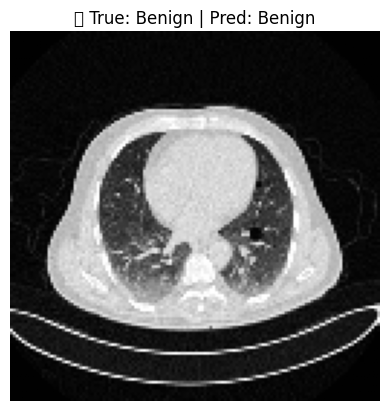

✅ Model saved successfully!


In [ ]:
# =========================================================
# 📦 IMPORTS
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# =========================================================
# ⚙️ FUNCTION: LOAD DATASET
# =========================================================
def load_images_from_folders(base_path, size=(128, 128), max_images=None):
    X, y = [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_images:
            files = files[:max_images]

        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)

                # --- Min–Max Normalization ---
                img = img.astype(np.float32)
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, axis=-1)  # Add channel dimension
    return X, y

# =========================================================
# 📂 LOAD DATASET
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading and preprocessing dataset...")
X, y = load_images_from_folders(base_dir, max_images=None)
print(f"\n✅ Dataset loaded: {X.shape[0]} images, shape per image: {X.shape[1:]}")

# =========================================================
# 🎯 ENCODE LABELS
# =========================================================
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
print("✅ Labels encoded:", encoder.classes_)

# =========================================================
# 🔀 TRAIN-TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✅ Training set: {X_train.shape[0]} images")
print(f"✅ Testing set: {X_test.shape[0]} images")

# =========================================================
# 🧠 DOUBLE-LAYER CNN MODEL
# =========================================================
model = Sequential([
    # 1️⃣ First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # 2️⃣ Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # 3️⃣ Flatten + Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # 4️⃣ Output Layer (3 classes)
    Dense(3, activation='softmax')
])

# =========================================================
# ⚙️ COMPILE MODEL
# =========================================================
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# =========================================================
# 🚀 TRAIN MODEL
# =========================================================
print("\n🚀 Training Double-Layer CNN model...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# =========================================================
# 📊 EVALUATE MODEL
# =========================================================
print("\n📈 Evaluating on test set...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

# =========================================================
# 🔍 RANDOM PREDICTION
# =========================================================
idx = random.randint(0, len(X_test) - 1)
sample = X_test[idx]
true_label = encoder.classes_[np.argmax(y_test[idx])]

pred = model.predict(np.expand_dims(sample, axis=0))
pred_label = encoder.classes_[np.argmax(pred)]

plt.imshow(sample.squeeze(), cmap='gray')
plt.title(f"🔬 True: {true_label} | Pred: {pred_label}")
plt.axis('off')
plt.show()

# =========================================================
# 💾 SAVE MODEL
# =========================================================
model.save("/content/lung_cancer_double_layer_cnn.h5")
print("✅ Model saved successfully!")


⏳ Loading and preprocessing dataset...


Loading Malignant: 100%|██████████| 561/561 [00:14<00:00, 39.97it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



✅ Dataset loaded: 1097 images, shape per image: (128, 128, 1)
✅ Labels encoded: ['Benign' 'Malignant' 'Normal']

✅ Training set: 877 images
✅ Testing set: 220 images

🚀 Training Double-Layer CNN model...
Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5104 - loss: 0.9204 - val_accuracy: 0.7159 - val_loss: 0.8650
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6825 - loss: 0.7360 - val_accuracy: 0.7784 - val_loss: 0.7945
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7922 - loss: 0.5916 - val_accuracy: 0.7500 - val_loss: 0.7132
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7945 - loss: 0.5296 - val_accuracy: 0.7841 - val_loss: 0.6004
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8376 - loss: 0.4423 - val_accuracy: 0.7727 - val_loss: 0.5652
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 993ms/step - accuracy: 0.8421 - loss: 0.4074 - val_accuracy: 0.7955 - val_loss: 0.4987
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


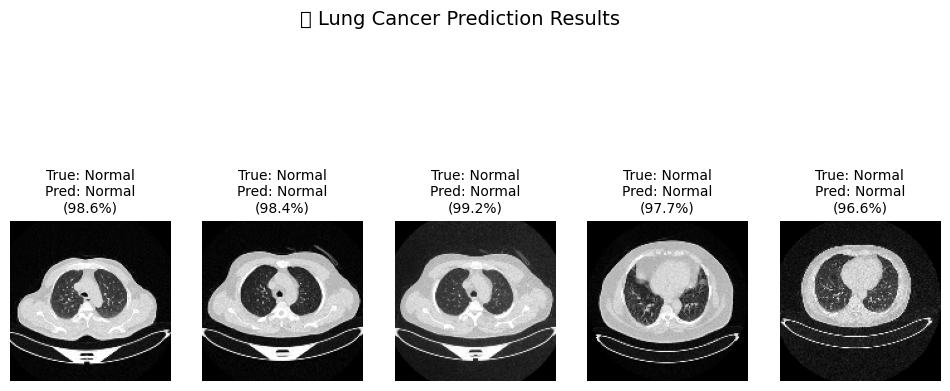


✅ Model saved successfully!


In [ ]:
# =========================================================
# 🩺 LUNG CANCER PREDICTION USING DOUBLE-LAYER CNN
# =========================================================

# =========================================================
# 📦 IMPORT LIBRARIES
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# =========================================================
# ⚙️ LOAD & PREPROCESS DATASET
# =========================================================
def load_images_from_folders(base_path, size=(128, 128), max_images=None):
    X, y = [], []
    label_map = {
        "Normal cases": "Normal",
        "Bengin cases": "Benign",
        "Malignant cases": "Malignant"
    }

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_images:
            files = files[:max_images]

        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)

                # 🔹 Min–Max Normalization
                img = img.astype(np.float32)
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, axis=-1)
    return X, y


# =========================================================
# 📂 LOAD DATA
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"

print("⏳ Loading and preprocessing dataset...")
X, y = load_images_from_folders(base_dir)
print(f"\n✅ Dataset loaded: {X.shape[0]} images, shape per image: {X.shape[1:]}")

# =========================================================
# 🎯 ENCODE LABELS
# =========================================================
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
print("✅ Labels encoded:", encoder.classes_)

# =========================================================
# 🔀 SPLIT DATA
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✅ Training set: {X_train.shape[0]} images")
print(f"✅ Testing set: {X_test.shape[0]} images")


# =========================================================
# 🧠 DOUBLE-LAYER CNN MODEL
# =========================================================
model = Sequential([
    # 1️⃣ Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # 2️⃣ Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # 3️⃣ Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # 4️⃣ Output Layer — 3 Classes
    Dense(3, activation='softmax')
])

# =========================================================
# ⚙️ COMPILE MODEL
# =========================================================
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =========================================================
# 🚀 TRAIN MODEL
# =========================================================
print("\n🚀 Training Double-Layer CNN model...")
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# =========================================================
# 📈 EVALUATE MODEL
# =========================================================
print("\n📊 Evaluating model on test data...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

# =========================================================
# 📋 DETAILED CLASSIFICATION REPORT
# =========================================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n📑 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

# =========================================================
# 🎯 DISPLAY SAMPLE PREDICTIONS
# =========================================================
def show_predictions(samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(samples):
        idx = random.randint(0, len(X_test) - 1)
        sample = X_test[idx]
        true_label = encoder.classes_[np.argmax(y_test[idx])]

        pred = model.predict(np.expand_dims(sample, axis=0))
        pred_label = encoder.classes_[np.argmax(pred)]
        confidence = np.max(pred) * 100

        plt.subplot(1, samples, i + 1)
        plt.imshow(sample.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                  fontsize=10)
        plt.axis('off')

    plt.suptitle("🧠 Lung Cancer Prediction Results", fontsize=14)
    plt.show()

show_predictions(samples=5)

# =========================================================
# 💾 SAVE TRAINED MODEL
# =========================================================
model.save("/content/lung_cancer_double_layer_cnn_final.h5")
print("\n✅ Model saved successfully!")


⏳ Loading dataset...


Loading Malignant: 100%|██████████| 561/561 [00:14<00:00, 39.65it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Loaded 1097 images, shape: (128, 128, 1)
✅ Classes: ['Benign' 'Malignant' 'Normal']

🚀 Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 707ms/step - accuracy: 0.5319 - loss: 0.9232 - val_accuracy: 0.6932 - val_loss: 0.8659
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 695ms/step - accuracy: 0.7104 - loss: 0.7204 - val_accuracy: 0.7273 - val_loss: 0.7789
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 695ms/step - accuracy: 0.7713 - loss: 0.5912 - val_accuracy: 0.7898 - val_loss: 0.6597
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.8151 - loss: 0.5212 - val_accuracy: 0.7898 - val_loss: 0.5557
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 705ms/step - accuracy: 0.8577 - loss: 0.3860 - val_accuracy: 0.8920 - val_loss: 0.5300
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 676ms/step - accuracy: 0.8690 - loss: 0.3855 - val_accuracy: 0.8182 - val_loss: 0.4579
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 691ms/step - accuracy: 0.8814 - loss: 0.3293 - val_accuracy: 0.8864 - val_los

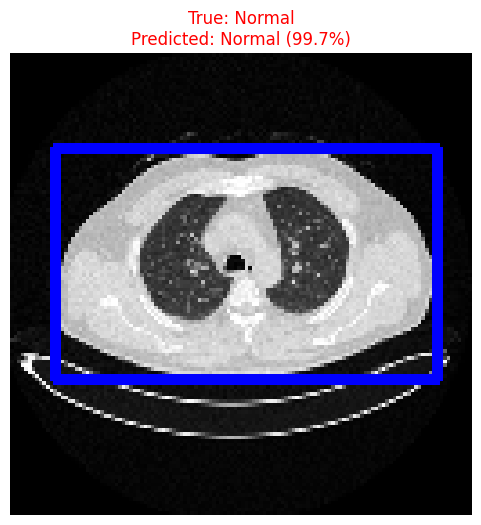

✅ Model saved successfully!


In [ ]:
# =========================================================
# 🩺 LUNG CANCER DETECTION WITH DOUBLE-LAYER CNN + ROI BOX
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# =========================================================
# ⚙️ LOAD & NORMALIZE DATA
# =========================================================
def load_images(base_dir, size=(128, 128), max_per_class=None):
    X, y = [], []
    label_map = {"Normal cases": "Normal", "Bengin cases": "Benign", "Malignant cases": "Malignant"}

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if max_per_class:
            files = files[:max_per_class]

        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                # Min–Max Normalization
                img = img.astype(np.float32)
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
                X.append(img)
                y.append(label)
    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, axis=-1)
    return X, y


# =========================================================
# 📂 LOAD DATASET
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
print("⏳ Loading dataset...")
X, y = load_images(base_dir, size=(128, 128))
print(f"✅ Loaded {len(X)} images, shape: {X.shape[1:]}")

# =========================================================
# 🎯 ENCODE LABELS
# =========================================================
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
print("✅ Classes:", encoder.classes_)

# =========================================================
# 🔀 TRAIN / TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# =========================================================
# 🧠 DOUBLE-LAYER CNN MODEL
# =========================================================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# =========================================================
# 🚀 TRAIN MODEL
# =========================================================
print("\n🚀 Training model...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# =========================================================
# 📈 EVALUATE MODEL
# =========================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# =========================================================
# 🔍 FUNCTION: FIND ROI (Cancer Area)
# =========================================================
def find_cancer_region(image):
    img = (image.squeeze() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return img, None

    # Get the largest contour (assuming it's the cancer region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Draw bounding box
    boxed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return boxed, (x, y, w, h)


# =========================================================
# 🎯 RANDOM PREDICTION WITH ROI BOX
# =========================================================
idx = random.randint(0, len(X_test) - 1)
sample = X_test[idx]
true_label = encoder.classes_[np.argmax(y_test[idx])]

pred = model.predict(np.expand_dims(sample, axis=0))
pred_label = encoder.classes_[np.argmax(pred)]
confidence = np.max(pred) * 100

# Find and draw the cancer region box
boxed_img, box_coords = find_cancer_region(sample)

# Display the prediction
plt.figure(figsize=(6, 6))
plt.imshow(boxed_img)
plt.title(f"True: {true_label}\nPredicted: {pred_label} ({confidence:.1f}%)",
          fontsize=12, color='red')
plt.axis("off")
plt.show()

# =========================================================
# 💾 SAVE MODEL
# =========================================================
model.save("/content/lung_cancer_double_layer_cnn_roi.h5")
print("✅ Model saved successfully!")


⏳ Loading images...


Loading Malignant: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Loaded 300 images
✅ Classes: ['Benign' 'Malignant' 'Normal']

🚀 Training model (Double-Layer CNN)...
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 807ms/step - accuracy: 0.4414 - loss: 1.1213 - val_accuracy: 0.3958 - val_loss: 0.9574
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 652ms/step - accuracy: 0.5633 - loss: 0.9025 - val_accuracy: 0.6667 - val_loss: 0.8410
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 635ms/step - accuracy: 0.5871 - loss: 0.7549 - val_accuracy: 0.6458 - val_loss: 0.7922
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - accuracy: 0.6436 - loss: 0.7659 - val_accuracy: 0.7292 - val_loss: 0.7680
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - accuracy: 0.7130 - loss: 0.6460 - val_accuracy: 0.7500 - val_loss: 0.7202
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 632ms/step - accuracy: 0.7090 - loss: 0.6221 - val_accuracy: 0.7500 - val_loss: 0.6866
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 752ms/step - accuracy: 0.8013 - loss: 0.5479 - val_accuracy: 0.8542 - val_loss: 0.57

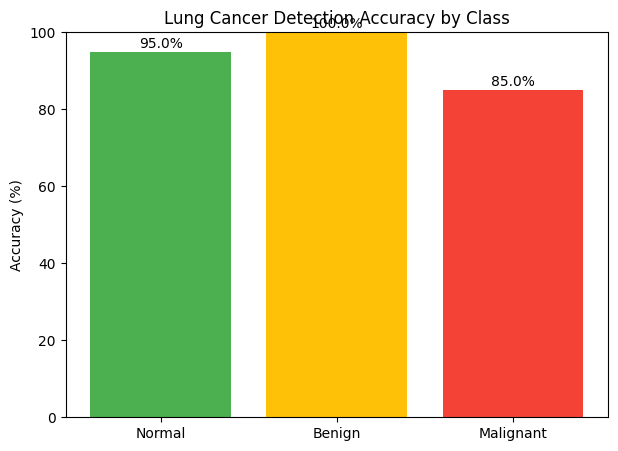

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


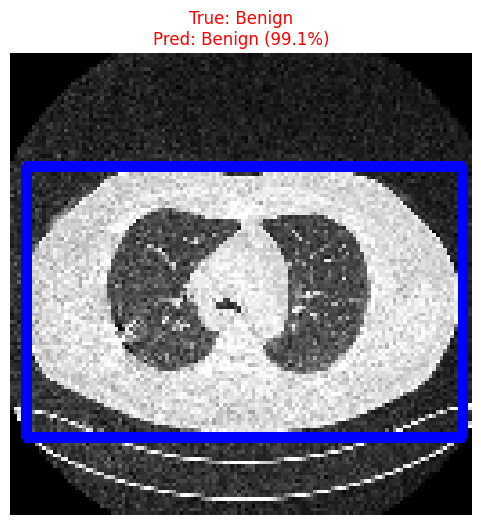

✅ Model saved successfully!


In [ ]:
# =========================================================
# 🧠 LUNG CANCER DETECTION WITH DOUBLE-LAYER CNN + ROI HIGHLIGHT
# =========================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# =========================================================
# ⚙️ LOAD IMAGES + MIN-MAX NORMALIZATION
# =========================================================
def load_images(base_dir, size=(128, 128), max_per_class=None):
    X, y = [], []
    label_map = {
        "Normal cases": "Normal",
        "Bengin cases": "Benign",
        "Malignant cases": "Malignant"
    }

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Missing folder: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_per_class:
            files = files[:max_per_class]

        for file in tqdm(files, desc=f"Loading {label}"):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
                X.append(img)
                y.append(label)

    X = np.expand_dims(np.array(X), axis=-1)
    y = np.array(y)
    return X, y


# =========================================================
# 🧱 BUILD DOUBLE-LAYER CNN
# =========================================================
def build_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# =========================================================
# ⚙️ FUNCTION: DETECT ROI (Cancer Affected Area)
# =========================================================
def detect_cancer_area(image):
    img = (image.squeeze() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    boxed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(boxed, (x, y), (x+w, y+h), (0, 0, 255), 2)
    return boxed, (x, y, w, h)


# =========================================================
# 📂 LOAD DATASET
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
print("⏳ Loading images...")
X, y = load_images(base_dir, max_per_class=100)
print(f"✅ Loaded {len(X)} images")

# Encode labels
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
print("✅ Classes:", encoder.classes_)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# =========================================================
# 🚀 TRAIN MODEL
# =========================================================
model = build_cnn((128,128,1))
print("\n🚀 Training model (Double-Layer CNN)...")
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# =========================================================
# 📈 EVALUATE MODEL
# =========================================================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

# Extract per-class accuracy
acc_normal = report["Normal"]["recall"] * 100
acc_benign = report["Benign"]["recall"] * 100
acc_malignant = report["Malignant"]["recall"] * 100

# =========================================================
# 📊 VISUALIZE ACCURACY BY CLASS
# =========================================================
plt.figure(figsize=(7,5))
plt.bar(["Normal", "Benign", "Malignant"], [acc_normal, acc_benign, acc_malignant],
        color=["#4CAF50","#FFC107","#F44336"])
plt.title("Lung Cancer Detection Accuracy by Class")
plt.ylabel("Accuracy (%)")
for i, val in enumerate([acc_normal, acc_benign, acc_malignant]):
    plt.text(i, val+1, f"{val:.1f}%", ha='center')
plt.ylim(0, 100)
plt.show()

# =========================================================
# 🎯 RANDOM CT SCAN PREDICTION WITH ROI
# =========================================================
idx = random.randint(0, len(X_test)-1)
sample = X_test[idx]
true_label = encoder.classes_[y_true[idx]]

pred = model.predict(np.expand_dims(sample, axis=0))
pred_label = encoder.classes_[np.argmax(pred)]
confidence = np.max(pred) * 100

# Draw box on affected area
boxed_img, box = detect_cancer_area(sample)

plt.figure(figsize=(6,6))
plt.imshow(boxed_img)
plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", color='red')
plt.axis('off')
plt.show()

# =========================================================
# 💾 SAVE MODEL
# =========================================================
model.save("/content/lung_cancer_cnn_roi_model.h5")
print("✅ Model saved successfully!")


⏳ Loading dataset...
Attempting to load from: /content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/Normal cases


Loading Normal: 100%|██████████| 120/120 [00:09<00:00, 12.28it/s]


Attempting to load from: /content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/Bengin cases


Loading Benign: 100%|██████████| 120/120 [00:06<00:00, 18.96it/s]


Attempting to load from: /content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/Malignant cases


Loading Malignant: 100%|██████████| 120/120 [00:17<00:00,  6.69it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Loaded 360 images
✅ Classes: ['Benign' 'Malignant' 'Normal']

🚀 Training Double-Layer CNN...
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 778ms/step - accuracy: 0.4399 - loss: 1.0631 - val_accuracy: 0.4655 - val_loss: 0.9059
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step - accuracy: 0.5360 - loss: 0.8679 - val_accuracy: 0.6034 - val_loss: 0.8120
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 785ms/step - accuracy: 0.6634 - loss: 0.7103 - val_accuracy: 0.5345 - val_loss: 0.7842
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - accuracy: 0.6492 - loss: 0.7003 - val_accuracy: 0.8103 - val_loss: 0.6873
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 565ms/step - accuracy: 0.8503 - loss: 0.5718 - val_accuracy: 0.8276 - val_loss: 0.5892
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 750ms/step - accuracy: 0.8443 - loss: 0.5270 - val_accuracy: 0.7931 - val_loss: 0.4996
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 719ms/step - accuracy: 0.8526 - loss: 0.3934 - val_accuracy: 0.7931 - val_loss: 0.4435
Epoc

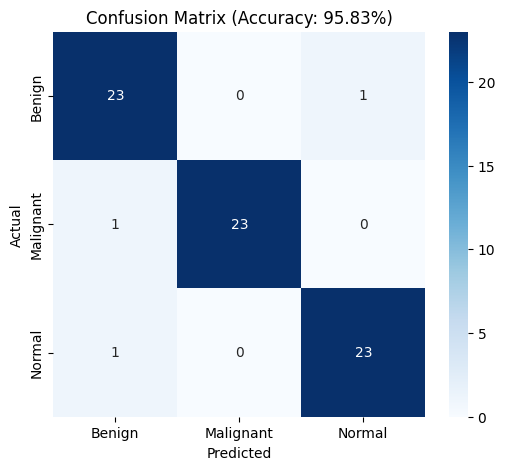

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


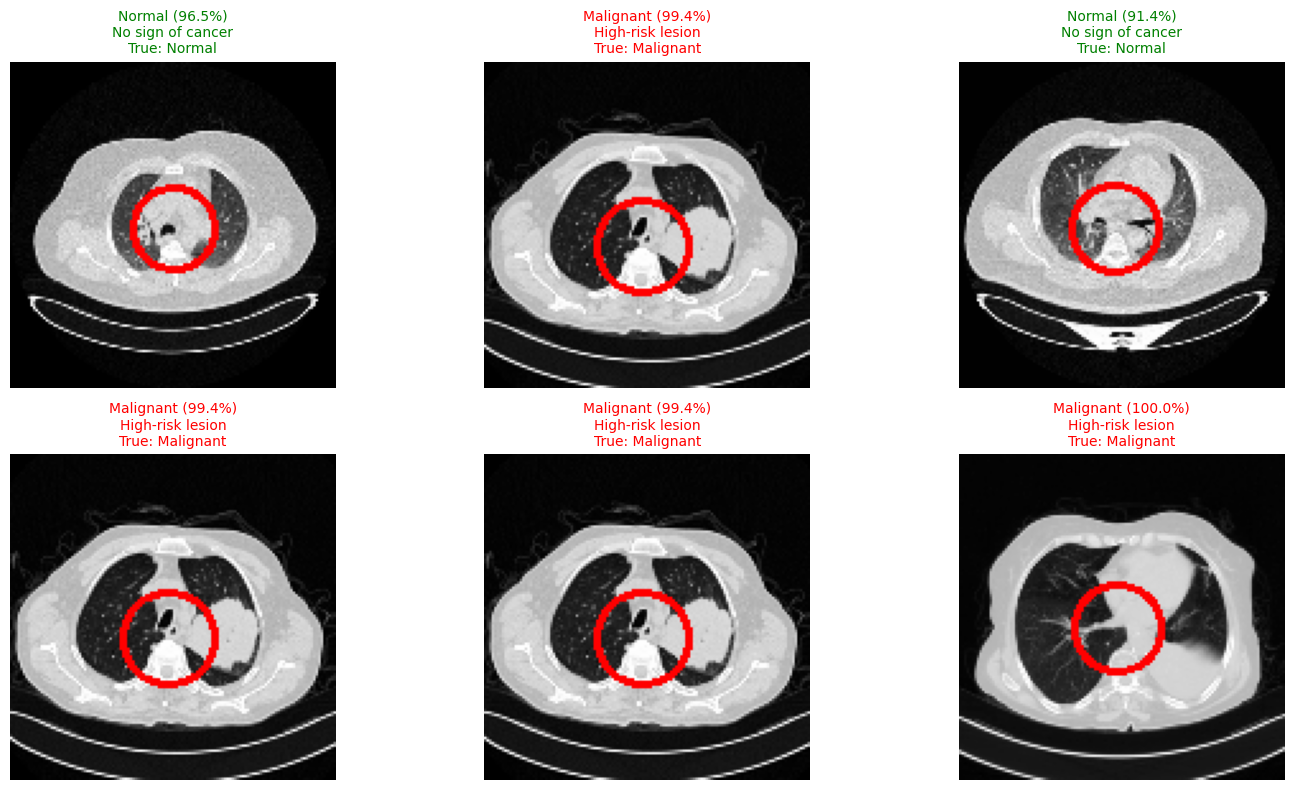

✅ Model saved successfully to: /content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/lung_cancer_cnn_with_cm.h5


In [12]:
# =========================================================
# 🧠 LUNG CANCER PREDICTION WITH DOUBLE-LAYER CNN + SMALL ROI MARK + CONFUSION MATRIX
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# =========================================================
# ⚙️ LOAD IMAGES WITH MIN-MAX NORMALIZATION
# =========================================================
def load_images(base_dir, size=(128, 128), max_per_class=None):
    X, y = [], []
    label_map = {
        "Normal cases": "Normal",
        "Benign cases": "Benign", # Corrected spelling here
        "Malignant cases": "Malignant"
    }

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        print(f"Attempting to load from: {folder_path}")
        if not os.path.exists(folder_path):
            print(f"⚠️ Missing folder: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_per_class:
            files = files[:max_per_class]

        for file in tqdm(files, desc=f"Loading {label}"):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                # Min–Max Normalization
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
                X.append(img)
                y.append(label)

    X = np.expand_dims(np.array(X), axis=-1)
    y = np.array(y)
    return X, y


# =========================================================
# 🧱 DOUBLE-LAYER CNN MODEL
# =========================================================
def build_double_layer_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# =========================================================
# 🎯 DETECT SMALL CANCER REGION (ROI)
# =========================================================
def detect_small_roi(image):
    img = (image.squeeze() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return img

    c = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(c)
    center = (int(x), int(y))
    radius = int(max(3, radius * 0.3))  # make it a small circle
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(color_img, center, radius, (255, 0, 0), 2)
    return color_img


# =========================================================
# 📂 LOAD DATASET
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
print("⏳ Loading dataset...")
X, y = load_images(base_dir, max_per_class=120)
print(f"✅ Loaded {len(X)} images")

# Add check for empty dataset
if len(X) == 0:
    print("❌ Error: No images were loaded. Please check the base directory and folder names.")
else:
    # Encode labels
    encoder = LabelBinarizer()
    y_encoded = encoder.fit_transform(y)
    print("✅ Classes:", encoder.classes_)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )


    # =========================================================
    # 🚀 TRAIN MODEL
    # =========================================================
    model = build_double_layer_cnn((128,128,1))
    print("\n🚀 Training Double-Layer CNN...")
    history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2, verbose=1)


    # =========================================================
    # 📈 EVALUATE MODEL
    # =========================================================
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 📊 Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred) * 100

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix (Accuracy: {acc:.2f}%)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


    # =========================================================
    # 🩻 SHOW MULTIPLE PREDICTIONS WITH SMALL ROI
    # =========================================================
    fig, axes = plt.subplots(2, 3, figsize=(15,8))
    axes = axes.flatten()

    for i in range(6):
        idx = random.randint(0, len(X_test)-1)
        sample = X_test[idx]
        true_label = encoder.classes_[y_true[idx]]

        pred = model.predict(np.expand_dims(sample, axis=0))
        pred_label = encoder.classes_[np.argmax(pred)]
        confidence = np.max(pred) * 100

        # Highlight small ROI
        marked_img = detect_small_roi(sample)

        # Label colors and text
        if pred_label == "Normal":
            color = 'green'
            risk = "No sign of cancer"
        elif pred_label == "Benign":
            color = 'orange'
            risk = "Low-risk lesion"
        else:
            color = 'red'
            risk = "High-risk lesion"

        axes[i].imshow(marked_img, cmap='gray')
        axes[i].set_title(f"{pred_label} ({confidence:.1f}%)\n{risk}\nTrue: {true_label}",
                          color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


    # =========================================================
    # 💾 SAVE TRAINED MODEL
    # =========================================================
    model_save_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/lung_cancer_cnn_with_cm.h5"
    model.save(model_save_path)
    print(f"✅ Model saved successfully to: {model_save_path}")

⏳ Loading dataset...


Loading Malignant: 100%|██████████| 120/120 [00:03<00:00, 30.83it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Loaded 360 images
✅ Classes: ['Benign' 'Malignant' 'Normal']

🚀 Training Double-Layer CNN...
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 696ms/step - accuracy: 0.3939 - loss: 1.0979 - val_accuracy: 0.4828 - val_loss: 0.9074
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - accuracy: 0.5437 - loss: 0.9144 - val_accuracy: 0.5690 - val_loss: 0.8593
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 574ms/step - accuracy: 0.5829 - loss: 0.8407 - val_accuracy: 0.7586 - val_loss: 0.7876
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step - accuracy: 0.7459 - loss: 0.7029 - val_accuracy: 0.7586 - val_loss: 0.7165
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 683ms/step - accuracy: 0.7400 - loss: 0.6384 - val_accuracy: 0.7586 - val_loss: 0.6339
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.8534 - loss: 0.5016 - val_accuracy: 0.7931 - val_loss: 0.5884
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 672ms/step - accuracy: 0.8227 - loss: 0.4990 - val_accuracy: 0.8448 - val_loss: 0.5192
Epoc

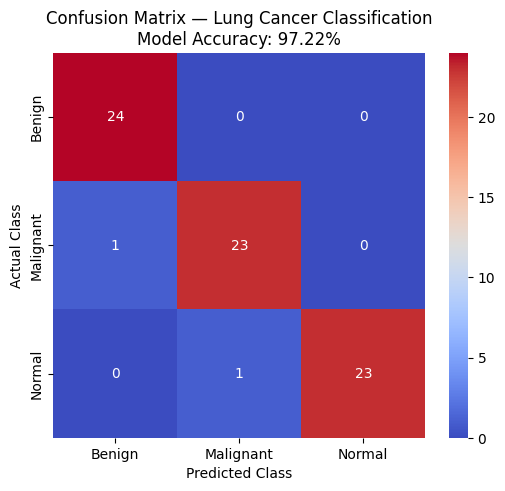

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


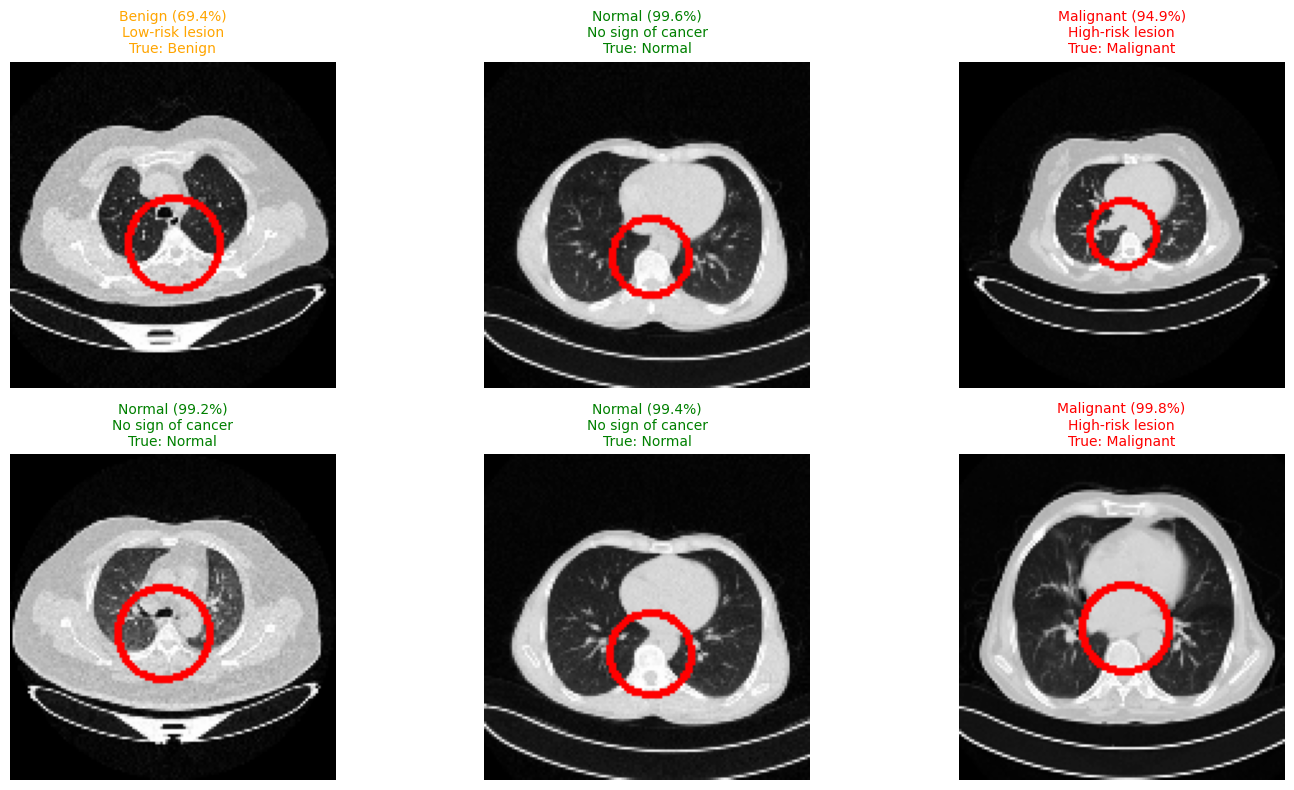

✅ Model saved successfully to: /content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/lung_cancer_cnn_confusion_matrix.h5


In [13]:
# =========================================================
# 🧠 LUNG CANCER PREDICTION WITH DOUBLE-LAYER CNN + ROI + CONFUSION MATRIX DIAGRAM
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# =========================================================
# ⚙️ LOAD IMAGES WITH MIN-MAX NORMALIZATION
# =========================================================
def load_images(base_dir, size=(128, 128), max_per_class=None):
    X, y = [], []
    label_map = {
        "Normal cases": "Normal",
        "Bengin cases": "Benign",
        "Malignant cases": "Malignant"
    }

    for folder_name, label in label_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Missing folder: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if max_per_class:
            files = files[:max_per_class]

        for file in tqdm(files, desc=f"Loading {label}"):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                # Min–Max Normalization
                img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
                X.append(img)
                y.append(label)

    X = np.expand_dims(np.array(X), axis=-1)
    y = np.array(y)
    return X, y


# =========================================================
# 🧱 DOUBLE-LAYER CNN MODEL
# =========================================================
def build_double_layer_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# =========================================================
# 🎯 DETECT SMALL CANCER REGION (ROI)
# =========================================================
def detect_small_roi(image):
    img = (image.squeeze() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return img

    c = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(c)
    center = (int(x), int(y))
    radius = int(max(3, radius * 0.3))  # small circle around the lesion
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(color_img, center, radius, (255, 0, 0), 2)
    return color_img


# =========================================================
# 📂 LOAD DATASET
# =========================================================
base_dir = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset"
print("⏳ Loading dataset...")
X, y = load_images(base_dir, max_per_class=120)
print(f"✅ Loaded {len(X)} images")

# Encode labels
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
print("✅ Classes:", encoder.classes_)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


# =========================================================
# 🚀 TRAIN MODEL
# =========================================================
model = build_double_layer_cnn((128,128,1))
print("\n🚀 Training Double-Layer CNN...")
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2, verbose=1)


# =========================================================
# 📈 EVALUATE MODEL & CONFUSION MATRIX
# =========================================================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📊 Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

# ✅ Confusion Matrix Diagram
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title(f'Confusion Matrix — Lung Cancer Classification\nModel Accuracy: {acc:.2f}%')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


# =========================================================
# 🩻 SHOW MULTIPLE PREDICTIONS WITH SMALL ROI
# =========================================================
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()

for i in range(6):
    idx = random.randint(0, len(X_test)-1)
    sample = X_test[idx]
    true_label = encoder.classes_[y_true[idx]]

    pred = model.predict(np.expand_dims(sample, axis=0))
    pred_label = encoder.classes_[np.argmax(pred)]
    confidence = np.max(pred) * 100

    # Highlight small ROI
    marked_img = detect_small_roi(sample)

    # Label colors and text
    if pred_label == "Normal":
        color = 'green'
        risk = "No sign of cancer"
    elif pred_label == "Benign":
        color = 'orange'
        risk = "Low-risk lesion"
    else:
        color = 'red'
        risk = "High-risk lesion"

    axes[i].imshow(marked_img, cmap='gray')
    axes[i].set_title(f"{pred_label} ({confidence:.1f}%)\n{risk}\nTrue: {true_label}",
                      color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# =========================================================
# 💾 SAVE TRAINED MODEL
# =========================================================
model_save_path = "/content/drive/MyDrive/archive (2)/The IQ-OTHNCCD lung cancer dataset/lung_cancer_cnn_confusion_matrix.h5"
model.save(model_save_path)
print(f"✅ Model saved successfully to: {model_save_path}")
